Warning message:
“Removed 7 rows containing missing values (geom_path).”

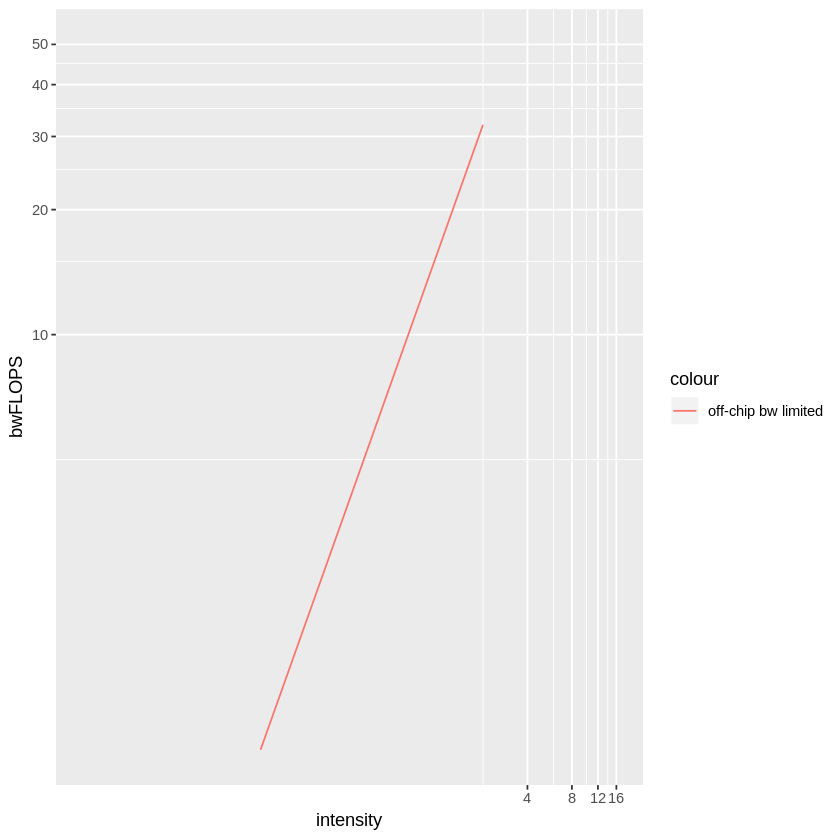

In [21]:
library(ggplot2)


intensity = 2^(-8:4)

flopsmax = 16 # GB/s
        
memband <- data.frame(intensity, intensity * 16, flopsmax )
colnames(memband) <- c("intensity", "bwFLOPS", 'cpuFLOPS')

aplot <- ggplot(memband, aes(x=intensity, y=bwFLOPS, color="off-chip bw limited") + 
                   geom_line(data=memband, aes(x=instensity, y=cpuFLOPS, color="cpu limited")) +

          geom_line() + coord_trans(x="log2", y="log2") + scale_y_continuous(limits=c(1,50)) 
       
aplot <- ggplot(memband, aes(x=cores, y=speedup, color="Speedup")) + geom_point() +
            geom_line(data=amdahl, aes(x=cores,y=cores, color="Ideal")) +
            geom_line(data=amdahl, aes(x=cores,y=limit, color="Limit")) +
            scale_color_manual(values = c("Speedup" = 'black','Ideal' = 'blue', 'Limit'='red')) + ylim(0,20)

print(aplot)

